In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
import joblib

In [2]:
df = pd.read_csv('Dataset_Model_Preprocessed.csv')
df = df.fillna(0)
X = df.drop('spot', axis=1)
y = df['spot']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

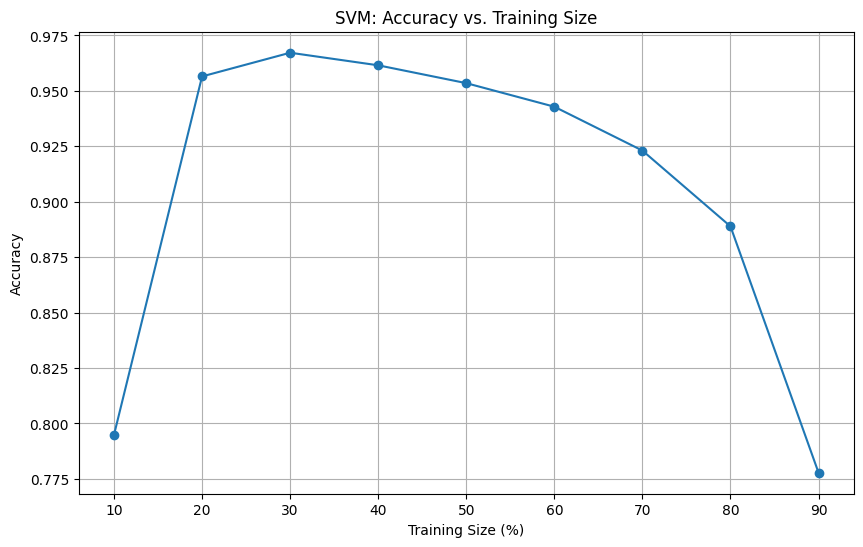

In [4]:
training_sizes = np.arange(0.1, 1.0, 0.1)
accuracy_scores_ts = []
for ts in training_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=1-ts, random_state=42, stratify=y_encoded)
    svm = SVC(kernel='rbf', C=1, gamma='scale')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores_ts.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, accuracy_scores_ts, marker='o')
plt.title('SVM: Accuracy vs. Training Size')
plt.xlabel('Training Size (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

c:\Users\Rifdatun Nafi'ah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


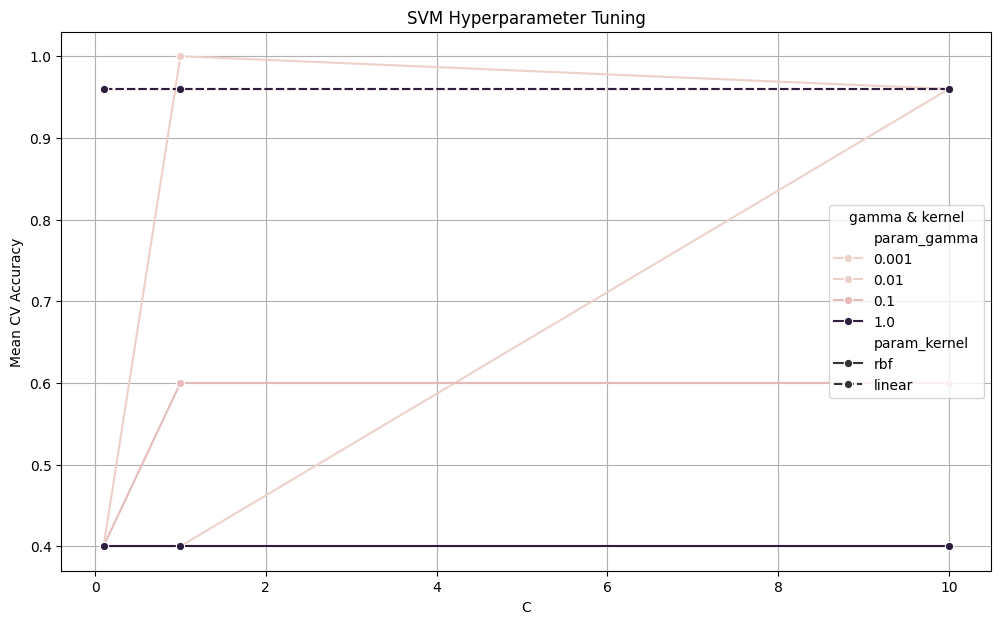

In [5]:
X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(X_scaled, y_encoded, test_size=0.7, random_state=42, stratify=y_encoded)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_ht, y_train_ht)

best_svm_model = grid_search.best_estimator_
y_pred_ht = best_svm_model.predict(X_test_ht)

results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x='param_C', y='mean_test_score', hue='param_gamma', style='param_kernel', marker='o')
plt.title('SVM Hyperparameter Tuning')
plt.xlabel('C')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.legend(title='gamma & kernel')
plt.show()

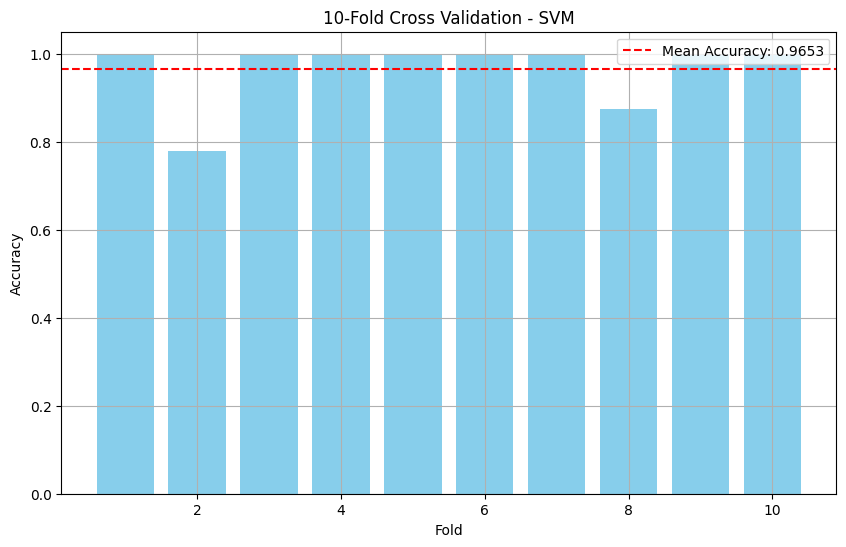

In [6]:
cv_scores = cross_val_score(best_svm_model, X_scaled, y_encoded, cv=10, scoring='accuracy', n_jobs=-1)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), cv_scores, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean Accuracy: {cv_scores.mean():.4f}')
plt.title('10-Fold Cross Validation - SVM')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

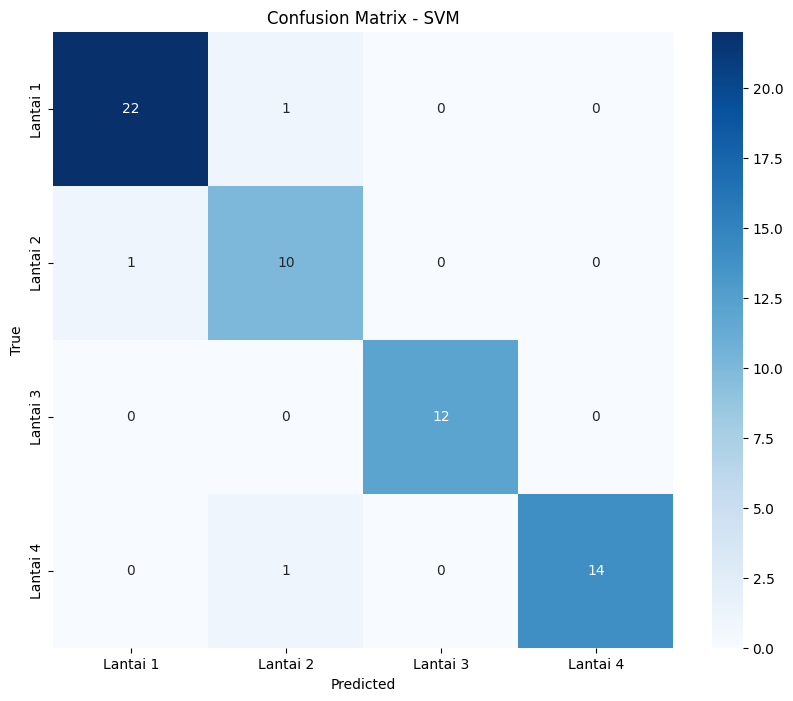

Accuracy: 0.9508
Precision: 0.9536
Recall: 0.9508
F1 Score: 0.9516


In [7]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_scaled, y_encoded, test_size=0.7, stratify=y_encoded, random_state=42)
best_svm_model.fit(X_train_final, y_train_final)
y_pred_final = best_svm_model.predict(X_test_final)
y_prob_final = best_svm_model.predict_proba(X_test_final)
cm = confusion_matrix(y_test_final, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(y_test_final, y_pred_final)
precision = precision_score(y_test_final, y_pred_final, average='weighted')
recall = recall_score(y_test_final, y_pred_final, average='weighted')
f1 = f1_score(y_test_final, y_pred_final, average='weighted')
print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")



Sensitivity & Specificity per Class:
Class 'Lantai 1': Sensitivity = 0.9565, Specificity = 0.9737
Class 'Lantai 2': Sensitivity = 0.9091, Specificity = 0.9600
Class 'Lantai 3': Sensitivity = 1.0000, Specificity = 1.0000
Class 'Lantai 4': Sensitivity = 0.9333, Specificity = 1.0000


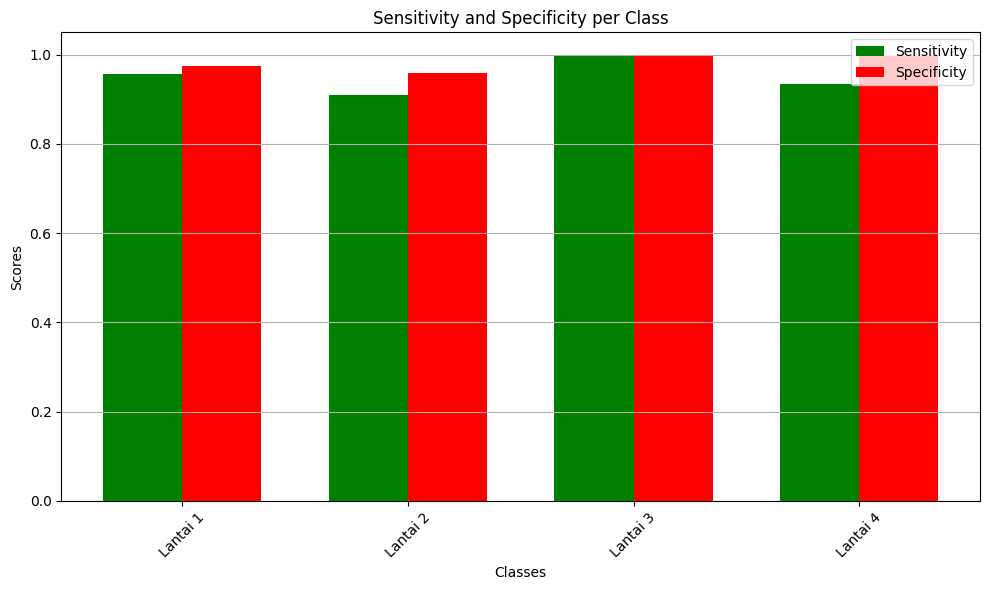

In [8]:
sensitivity = []
specificity = []
print("\nSensitivity & Specificity per Class:")
for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    se = TP / (TP + FN) if (TP + FN) > 0 else 0
    sp = TN / (TN + FP) if (TN + FP) > 0 else 0
    sensitivity.append(se)
    specificity.append(sp)
    print(f"Class '{le.classes_[i]}': Sensitivity = {se:.4f}, Specificity = {sp:.4f}")

avg_sensitivity = np.mean(sensitivity)
avg_specificity = np.mean(specificity)

# --- Plotting Sensitivity and Specificity ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(num_classes)
plt.bar(index, sensitivity, bar_width, label='Sensitivity', color='g')
plt.bar(index + bar_width, specificity, bar_width, label='Specificity', color='r')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Sensitivity and Specificity per Class')
plt.xticks(index + bar_width / 2, le.classes_, rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

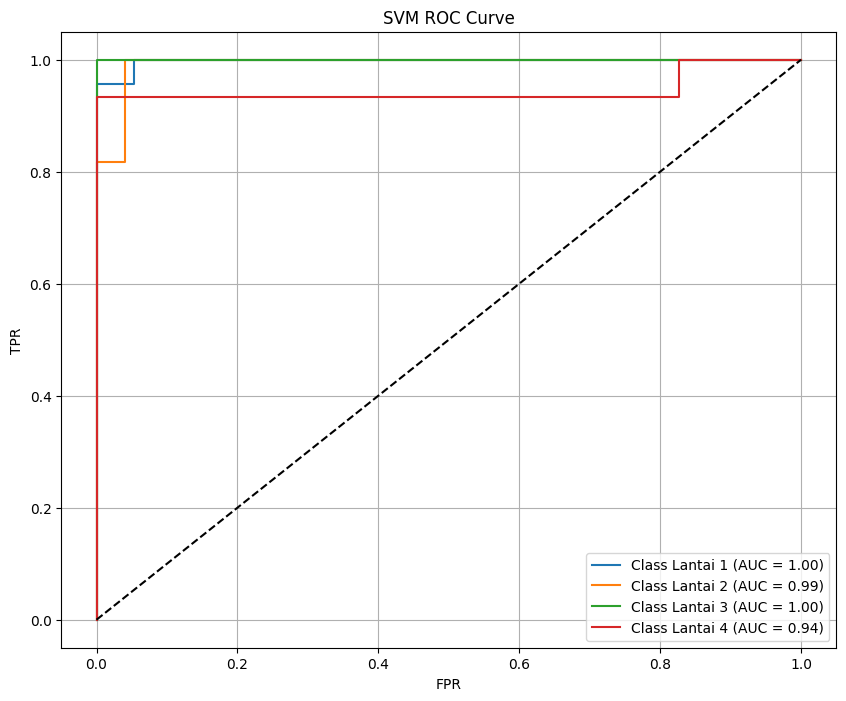

In [9]:
y_test_bin = label_binarize(y_test_final, classes=np.arange(num_classes))
fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("SVM ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()

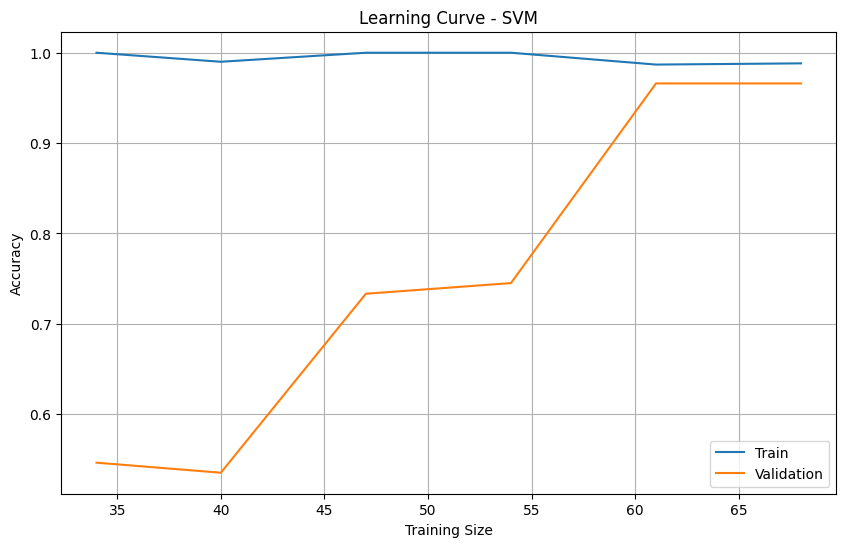

In [10]:
train_sizes, train_scores, val_scores = learning_curve(best_svm_model, X_scaled, y_encoded, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.title('Learning Curve - SVM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
sample_indices = np.random.choice(len(X_test_final), 5, replace=False)
sample_X = X_test_final[sample_indices]
sample_y = y_test_final[sample_indices]
sample_preds = best_svm_model.predict(sample_X)

for i in range(5):
    actual = le.inverse_transform([sample_y[i]])[0]
    pred = le.inverse_transform([sample_preds[i]])[0]
    print(f"Sample {i+1}: Actual = {actual} | Predicted = {pred}")

Sample 1: Actual = Lantai 2 | Predicted = Lantai 2
Sample 2: Actual = Lantai 3 | Predicted = Lantai 3
Sample 3: Actual = Lantai 1 | Predicted = Lantai 1
Sample 4: Actual = Lantai 2 | Predicted = Lantai 2
Sample 5: Actual = Lantai 2 | Predicted = Lantai 2


In [12]:
sample_indices = np.random.choice(len(X_test_final), 5, replace=False)
sample_X = X_test_final[sample_indices]
sample_y_actual = y_test_final[sample_indices]
sample_predictions = best_svm_model.predict(sample_X)
sample_probabilities = best_svm_model.predict_proba(sample_X)

print("\nSample Predictions:")
for i, idx in enumerate(sample_indices):
    actual_label = le.inverse_transform([sample_y_actual[i]])[0]
    predicted_label = le.inverse_transform([sample_predictions[i]])[0]
    print(f"Sample {i+1}:")
    print(f"  Actual Spot: {actual_label}")
    print(f"  Predicted Spot: {predicted_label}")
    print(f"  Prediction Probabilities: {sample_probabilities[i]}")
    print("-" * 30)



Sample Predictions:
Sample 1:
  Actual Spot: Lantai 1
  Predicted Spot: Lantai 1
  Prediction Probabilities: [0.44753091 0.37078846 0.11268522 0.06899541]
------------------------------
Sample 2:
  Actual Spot: Lantai 3
  Predicted Spot: Lantai 3
  Prediction Probabilities: [0.11469848 0.13458765 0.6647534  0.08596048]
------------------------------
Sample 3:
  Actual Spot: Lantai 1
  Predicted Spot: Lantai 1
  Prediction Probabilities: [0.8177986  0.09266281 0.04502472 0.04451388]
------------------------------
Sample 4:
  Actual Spot: Lantai 3
  Predicted Spot: Lantai 3
  Prediction Probabilities: [0.13615901 0.18844947 0.59429994 0.08109159]
------------------------------
Sample 5:
  Actual Spot: Lantai 3
  Predicted Spot: Lantai 3
  Prediction Probabilities: [0.10561813 0.07254634 0.71915135 0.10268418]
------------------------------


In [13]:
from sklearn.metrics import log_loss

# Log Loss: semakin kecil, semakin baik
logloss = log_loss(y_test_final, y_prob_final)
print(f"\nLog Loss (SVM): {logloss:.4f}")



Log Loss (SVM): 0.4187


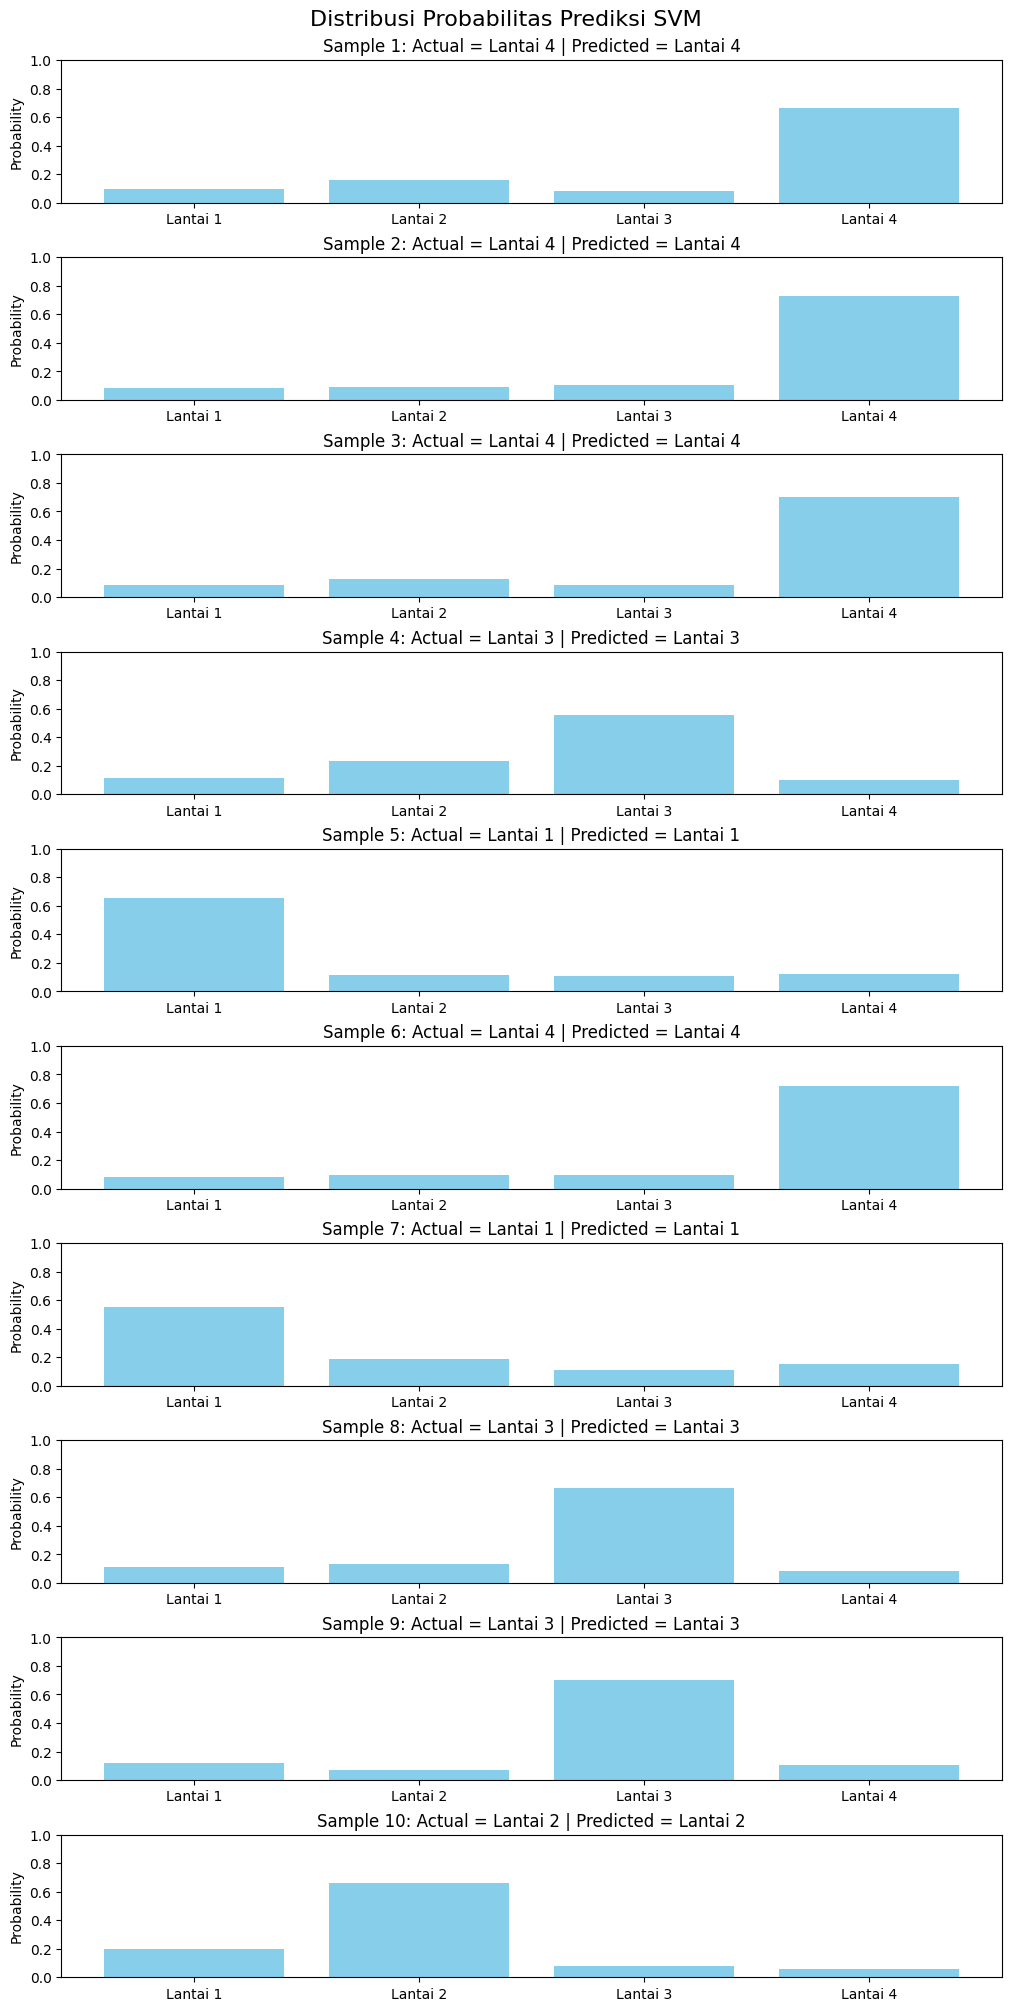

In [14]:
import matplotlib.pyplot as plt

# Ambil 10 sample dari data uji
n_samples = 10
indices = np.random.choice(len(X_test_final), n_samples, replace=False)
probs_sample = y_prob_final[indices]
true_labels = y_test_final[indices]
pred_labels = best_svm_model.predict(X_test_final[indices])

# Plot distribusi probabilitas
fig, axes = plt.subplots(n_samples, 1, figsize=(10, n_samples * 2), constrained_layout=True)
for i, ax in enumerate(axes):
    ax.bar(le.classes_, probs_sample[i], color='skyblue')
    actual = le.classes_[true_labels[i]]
    predicted = le.classes_[pred_labels[i]]
    ax.set_title(f"Sample {i+1}: Actual = {actual} | Predicted = {predicted}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
plt.suptitle("Distribusi Probabilitas Prediksi SVM", fontsize=16)
plt.show()


In [16]:
print("\n--- Final Model Evaluation (SVM) ---")
print("Best Parameters:")
print(f"  Kernel: {grid_search.best_params_['kernel']}")
print(f"  C: {grid_search.best_params_['C']}")
print(f"  Gamma: {grid_search.best_params_['gamma']}")
print(f"Cross-Validation Accuracy (Mean): {cv_scores.mean():.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Average AUC: {np.mean(list(roc_auc.values())):.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")



--- Final Model Evaluation (SVM) ---
Best Parameters:
  Kernel: rbf
  C: 1
  Gamma: 0.01
Cross-Validation Accuracy (Mean): 0.9653
Test Accuracy: 0.9508
Precision (weighted): 0.9536
Recall (weighted): 0.9508
F1 Score (weighted): 0.9516
Average AUC: 0.9838
Average Sensitivity: 0.9497
Average Specificity: 0.9834


In [17]:
# Save model, scaler, encoder, dan nama kolom
joblib.dump(grid_search.best_estimator_, 'svm_best_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(X.columns.tolist(), 'ap_columns.joblib')


['ap_columns.joblib']

In [18]:

import joblib
joblib.dump(grid_search.best_estimator_, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

PROTOTYPE
